In [6]:
reference_path = "../data/rsva/reference/EPI_ISL_412866_RSVA_ref.fasta"
sample_path = "../data/rsva/samples/hRSV_A_New_Zealand_IESR-VR0745_2021/genome.fasta"
kmer_size = 150
tolerance = 3

In [7]:
import pandas as pd

def read_fasta_to_dataframe(fasta_file):
    """Reads a FASTA file and returns a DataFrame with sequence IDs and sequences."""
    with open(fasta_file, 'r') as file:
        sequences = []
        sequence_id = ''
        sequence = ''
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # Header line
                if sequence:  # Save previous sequence before starting a new one
                    sequences.append([sequence_id, sequence])
                    sequence = ''  # Reset sequence
                sequence_id = line[1:]  # Remove '>' and take the rest as ID
            else:
                sequence += line
        if sequence:  # Ensure the last sequence is also added
            sequences.append([sequence_id, sequence])
    
    # Creating a DataFrame
    df = pd.DataFrame(sequences, columns=['ID', 'Sequence'])
    return df

In [8]:
df_ref = read_fasta_to_dataframe(reference_path)

In [9]:
df_sample = read_fasta_to_dataframe(sample_path)

In [10]:
df_ref

,ID,Sequence
0,EPI_ISL_412866,GTAAACCAAAAAAATGGGGCAAATAAGAATTTGATAAGTACCACTT...


In [11]:
df_sample

,ID,Sequence
0,hRSV/A/New_Zealand/IESR-VR0745/2021|EPI_ISL_16...,-------------------------------------GTACCACTT...


In [12]:
def sliding_window_matches(seq1: str, seq2: str, window_size: int = 150) -> list:
    """
    Counts the number of matches in a sliding window between two strings efficiently.

    Parameters:
        seq1 (str): First string.
        seq2 (str): Second string of the same length as seq1.
        window_size (int): The size of the sliding window. Default is 150.

    Returns:
        list: A list of match counts for each sliding window position.
    """
    if len(seq1) != len(seq2):
        raise ValueError("Both sequences must have the same length.")

    # Pre-process strings to map 'A', 'T', 'C', 'G' to numbers for efficiency.
    def encode(sequence):
        mapping = {"A": 0, "T": 1, "C": 2, "G": 3}
        return [mapping.get(char, -1) for char in sequence]  # Map invalid chars to -1.

    encoded_seq1 = encode(seq1)
    encoded_seq2 = encode(seq2)

    # Initialize the match count for the first window.
    current_match_count = sum(
        1 for i in range(window_size) if encoded_seq1[i] == encoded_seq2[i] and encoded_seq1[i] != -1
    )
    match_counts = [current_match_count]

    # Slide the window across the sequences.
    for i in range(window_size, len(seq1)):
        # Remove the effect of the outgoing element and add the incoming element.
        if encoded_seq1[i - window_size] == encoded_seq2[i - window_size] and encoded_seq1[i - window_size] != -1:
            current_match_count -= 1
        if encoded_seq1[i] == encoded_seq2[i] and encoded_seq1[i] != -1:
            current_match_count += 1

        match_counts.append(current_match_count)

    return match_counts


# Example usage:
if __name__ == "__main__":
    string1 = "AGCTTAGCTAGCTTAGCTAGCTTAGCTAGCTT" * 10
    string2 = "AGCTTAGATCGCTTAGCTAGCTTGGCTAGCTT" * 10
    window = 150

    result = sliding_window_matches(string1, string2, window)
    print(result)


[136, 136, 135, 135, 135, 135, 135, 135, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 136, 136, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 135, 135, 135, 135, 135, 135, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 136, 136, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 135, 135, 135, 135, 135, 135, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 136, 136, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 135, 135, 135, 135, 135, 135, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 136, 136, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 135, 135, 135, 135, 135, 135, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 136, 136, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 135, 135, 135, 135, 135, 135, 136, 136, 137]


In [41]:
# Example usage:
if __name__ == "__main__":
    string1 = df_ref["Sequence"].values.tolist()[0]
    string2 = df_sample["Sequence"].values.tolist()[0]
    window = 150

    result = sliding_window_matches(string1, string2, window)
    # print(result)


In [38]:
import numpy as np
(np.array(result)>140).astype(int).sum()

np.int64(14647)

In [39]:
len(result)

15076

In [40]:
import numpy as np

def process_sample(seq1: str, seq2: str, sample_id: str, window_size: int = 150, threshold: int = 145, output_dir: str = 'output'):
    """
    Processes a single sample by computing the binary match results and saving them to a file.

    Parameters:
        seq1 (str): Reference sequence.
        seq2 (str): Sample sequence.
        sample_id (str): Unique identifier for the sample.
        window_size (int): Size of the sliding window.
        threshold (int): Threshold for binary conversion.
        output_dir (str): Directory to save the output file.
    """
    def encode(sequence):
        mapping = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        return np.array([mapping.get(base, -1) for base in sequence], dtype=int)  # Map invalid chars to -1

    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be of the same length.")

    encoded_seq1 = encode(seq1)
    encoded_seq2 = encode(seq2)

    # Initialize match count for the first window
    current_match_count = np.sum(
        (encoded_seq1[:window_size] == encoded_seq2[:window_size]) & (encoded_seq1[:window_size] != -1)
    )
    match_counts = [current_match_count]

    # Slide the window
    for i in range(window_size, len(seq1)):
        # Subtract the outgoing element
        if encoded_seq1[i - window_size] == encoded_seq2[i - window_size] and encoded_seq1[i - window_size] != -1:
            current_match_count -= 1
        # Add the incoming element
        if encoded_seq1[i] == encoded_seq2[i] and encoded_seq1[i] != -1:
            current_match_count += 1
        match_counts.append(current_match_count)

    # Convert match counts to binary results based on the threshold
    binary_result = (np.array(match_counts) > threshold).astype(np.uint8)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save binary result to a file
    output_file = os.path.join(output_dir, f'sample_{sample_id}.npy')
    np.save(output_file, binary_result)

    print(f"Sample {sample_id} processed and saved to {output_file}")


In [ ]:
from multiprocessing import Pool
import os

def worker(args):
    seq1, seq2, sample_id = args
    process_sample(seq1, seq2, sample_id)

if __name__ == "__main__":
    reference_sequence = load_reference_sequence()  # Implement this function to load your reference sequence

    # Prepare a list of sample sequences and IDs
    samples = load_samples()  # Implement this function to return a list of tuples (sequence, sample_id)

    # Create arguments for each worker
    args_list = [(reference_sequence, sample_seq, sample_id) for sample_seq, sample_id in samples]

    # Number of processes can be adjusted based on your CPU cores
    with Pool(processes=8) as pool:
        pool.map(worker, args_list)


In [ ]:
import pandas as pd
import numpy as np
import os

def aggregate_results(output_dir: str = 'output') -> pd.DataFrame:
    """
    Aggregates binary results from all samples into a Pandas DataFrame.

    Parameters:
        output_dir (str): Directory where sample output files are stored.

    Returns:
        pd.DataFrame: DataFrame where each row represents a sample, and each column represents a position in the sequence.
    """
    # List all .npy files in the output directory
    file_list = [f for f in os.listdir(output_dir) if f.endswith('.npy')]

    data = []
    sample_ids = []

    for filename in sorted(file_list):  # Sort to maintain consistent order
        sample_id = filename.replace('sample_', '').replace('.npy', '')
        file_path = os.path.join(output_dir, filename)
        binary_result = np.load(file_path)
        data.append(binary_result)
        sample_ids.append(sample_id)

    # Convert data to a 2D NumPy array
    data_array = np.vstack(data)

    # Create a DataFrame
    df = pd.DataFrame(data_array, index=sample_ids)
    df.index.name = 'SampleID'

    return df

# Usage
if __name__ == "__main__":
    df = aggregate_results('output')
    print(df)
    # Optionally, save DataFrame to a file
    df.to_csv('aggregated_results.csv')


In [54]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO


def read_fasta(file_path):
    """Reads a FASTA file and returns the sequence as a string."""
    with open(file_path, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            return str(record.seq)


def sliding_window_matches(seq1, seq2, window_size=150, threshold=145):
    """
    Generates a binary list indicating whether the number of matches in a sliding window
    exceeds a given threshold.

    Parameters:
        seq1 (str): Reference sequence.
        seq2 (str): Sample sequence.
        window_size (int): Size of the sliding window.
        threshold (int): Threshold for match counts.

    Returns:
        list: A binary list (0 or 1) indicating if the match count exceeds the threshold.
    """
    def encode(sequence):
        mapping = {"A": 0, "T": 1, "C": 2, "G": 3}
        return np.array([mapping.get(char, -1) for char in sequence], dtype=int)  # Map invalid chars to -1

    if len(seq1) != len(seq2):
        raise ValueError("Sequences must have the same length.")

    encoded_seq1 = encode(seq1)
    encoded_seq2 = encode(seq2)

    # Initialize match count for the first window
    current_match_count = np.sum(
        (encoded_seq1[:window_size] == encoded_seq2[:window_size]) & (encoded_seq1[:window_size] != -1)
    )
    match_counts = [current_match_count]

    # Slide the window
    for i in range(window_size, len(seq1)):
        # Subtract the outgoing element
        if encoded_seq1[i - window_size] == encoded_seq2[i - window_size] and encoded_seq1[i - window_size] != -1:
            current_match_count -= 1
        # Add the incoming element
        if encoded_seq1[i] == encoded_seq2[i] and encoded_seq1[i] != -1:
            current_match_count += 1
        match_counts.append(current_match_count)

    # Convert match counts to binary results based on the threshold
    binary_result = (np.array(match_counts) > threshold).astype(np.uint8)
    return binary_result


def process_all_samples(reference_path, samples_dir, output_dir, window_size=150, threshold=145):
    """
    Processes all samples against the reference and aggregates binary results.

    Parameters:
        reference_path (str): Path to the reference FASTA file.
        samples_dir (str): Directory containing sample directories with genome.fasta files.
        output_dir (str): Directory to save individual binary results.
        window_size (int): Size of the sliding window.
        threshold (int): Threshold for binary match results.

    Returns:
        pd.DataFrame: Aggregated binary results as a DataFrame.
    """
    # Read the reference sequence
    reference_seq = read_fasta(reference_path)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Prepare to aggregate results
    aggregated_data = []
    sample_ids = []

    # Iterate through sample directories
    for sample_dir in sorted(os.listdir(samples_dir)):
        sample_path = os.path.join(samples_dir, sample_dir)
        genome_file = os.path.join(sample_path, "genome.fasta")

        if not os.path.isfile(genome_file):
            print(f"Warning: No genome.fasta found in {sample_path}. Skipping.")
            continue

        # Read the sample genome sequence
        sample_seq = read_fasta(genome_file)

        # Compute binary result for this sample
        binary_result = sliding_window_matches(reference_seq, sample_seq, window_size, threshold)

        # Save binary result to a file
        output_file = os.path.join(output_dir, f"{sample_dir}_binary.npy")
        np.save(output_file, binary_result)

        print(f"Processed {sample_dir}, results saved to {output_file}")

        # Append binary result to aggregation
        aggregated_data.append(binary_result)
        sample_ids.append(sample_dir)

    # Aggregate all results into a DataFrame
    aggregated_array = np.vstack(aggregated_data)
    df = pd.DataFrame(aggregated_array, index=sample_ids)
    df.index.name = "SampleID"

    return df


# Example Usage
if __name__ == "__main__":

    # reference_path = "../data/rsva/reference/EPI_ISL_412866_RSVA_ref.fasta"
    # sample_path = "../data/rsva/samples/hRSV_A_New_Zealand_IESR-VR0745_2021/genome.fasta"
    
    reference_path = "../data/rsva/reference/EPI_ISL_412866_RSVA_ref.fasta"
    # samples_dir = "../data/rsva/samples/"
    samples_dir = "../../kmer/data/rsva/samples/separated/"
    output_dir = "output/binary_results"

    # Process all samples and aggregate results
    aggregated_df = process_all_samples(reference_path, samples_dir, output_dir)

    # Save aggregated results to a CSV file
    aggregated_df.to_csv("output/aggregated_results.csv")
    print("Aggregated results saved to output/aggregated_results.csv")


Processed EPI_ISL_412866, results saved to output/binary_results/EPI_ISL_412866_binary.npy
Processed hRSV_A_Argentina_159_2004, results saved to output/binary_results/hRSV_A_Argentina_159_2004_binary.npy
Processed hRSV_A_Argentina_170_2005, results saved to output/binary_results/hRSV_A_Argentina_170_2005_binary.npy
Processed hRSV_A_Argentina_177_2006, results saved to output/binary_results/hRSV_A_Argentina_177_2006_binary.npy
Processed hRSV_A_Argentina_ARG-001_2015, results saved to output/binary_results/hRSV_A_Argentina_ARG-001_2015_binary.npy
Processed hRSV_A_Argentina_ARG-001sanger_2015, results saved to output/binary_results/hRSV_A_Argentina_ARG-001sanger_2015_binary.npy
Processed hRSV_A_Argentina_ARG-003_2015, results saved to output/binary_results/hRSV_A_Argentina_ARG-003_2015_binary.npy
Processed hRSV_A_Argentina_ARG-007_2016, results saved to output/binary_results/hRSV_A_Argentina_ARG-007_2016_binary.npy
Processed hRSV_A_Argentina_ARG-009_2016, results saved to output/binary_re

In [55]:
df = pd.read_csv("output/aggregated_results.csv", index_col="SampleID")

In [56]:
df

,0,1,2,3,4,5,6,7,8,9,...,15066,15067,15068,15069,15070,15071,15072,15073,15074,15075
SampleID,,,,,,,,,,,,,,,,,,,,,
EPI_ISL_412866,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
hRSV_A_Argentina_159_2004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hRSV_A_Argentina_170_2005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hRSV_A_Argentina_177_2006,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
hRSV_A_Argentina_ARG-001_2015,0,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hRSV_a_Slovakia_1342_2023,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
hRSV_a_Slovakia_1532_2023,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
hRSV_a_Slovakia_1533_2023,0,0,0,0,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0


In [62]:
df.sum(axis=0).argmax()

np.int64(11505)

In [58]:
df.loc['hRSV_A_Argentina_PAIS-ELZ-34_2022'].sum()

np.int64(13340)

In [68]:
df_ref['Sequence'].values[0].__len__()-150

15075

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rel_cons(df):
    
    # Assuming df has columns 'position', 'value_relaxed', and 'value_other'
    x = df.columns.values.flatten()
    y = df.sum().values.flatten()
    # Finding change indices for y
    change_indices_y = np.where(y[:-1] != y[1:])[0]
    change_indices_y = np.concatenate(([0], change_indices_y, [len(y) - 1]))
    
    # Getting the corresponding x and y values for both datasets
    x_steps_y = x[change_indices_y]
    y_steps = y[change_indices_y]

    x_steps_y = np.append(x_steps_y, x_steps_y[-1] + 1)  # Add 1 or an appropriate increment
    y_steps = np.append(y_steps, 0)
    

    # Creating the plot
    plt.figure(figsize=(12, 6), dpi=300)
    plt.step(x_steps_y, y_steps, where='post', label='# dereplicated covered genomes', color='blue')  # Specify color for y
    
    # Set title and labels
    plt.title('Histogram of the kmer coverage by their position | kmer size = 150| 3 changes max')
    plt.xlabel('Kmer Start Position')
    plt.ylabel('Frequency')
    
    # Setting y-axis limits if needed
    # plt.ylim(-0.1, 1.1)
    
    # Add a legend
    plt.legend()

    # plt.savefig(f'Comparison_of_Conservative_frequencies_{SAMPLE_NAME}_{KMER_SIZE}.png', dpi=300)
    
    # Display the plot
    plt.show()
    


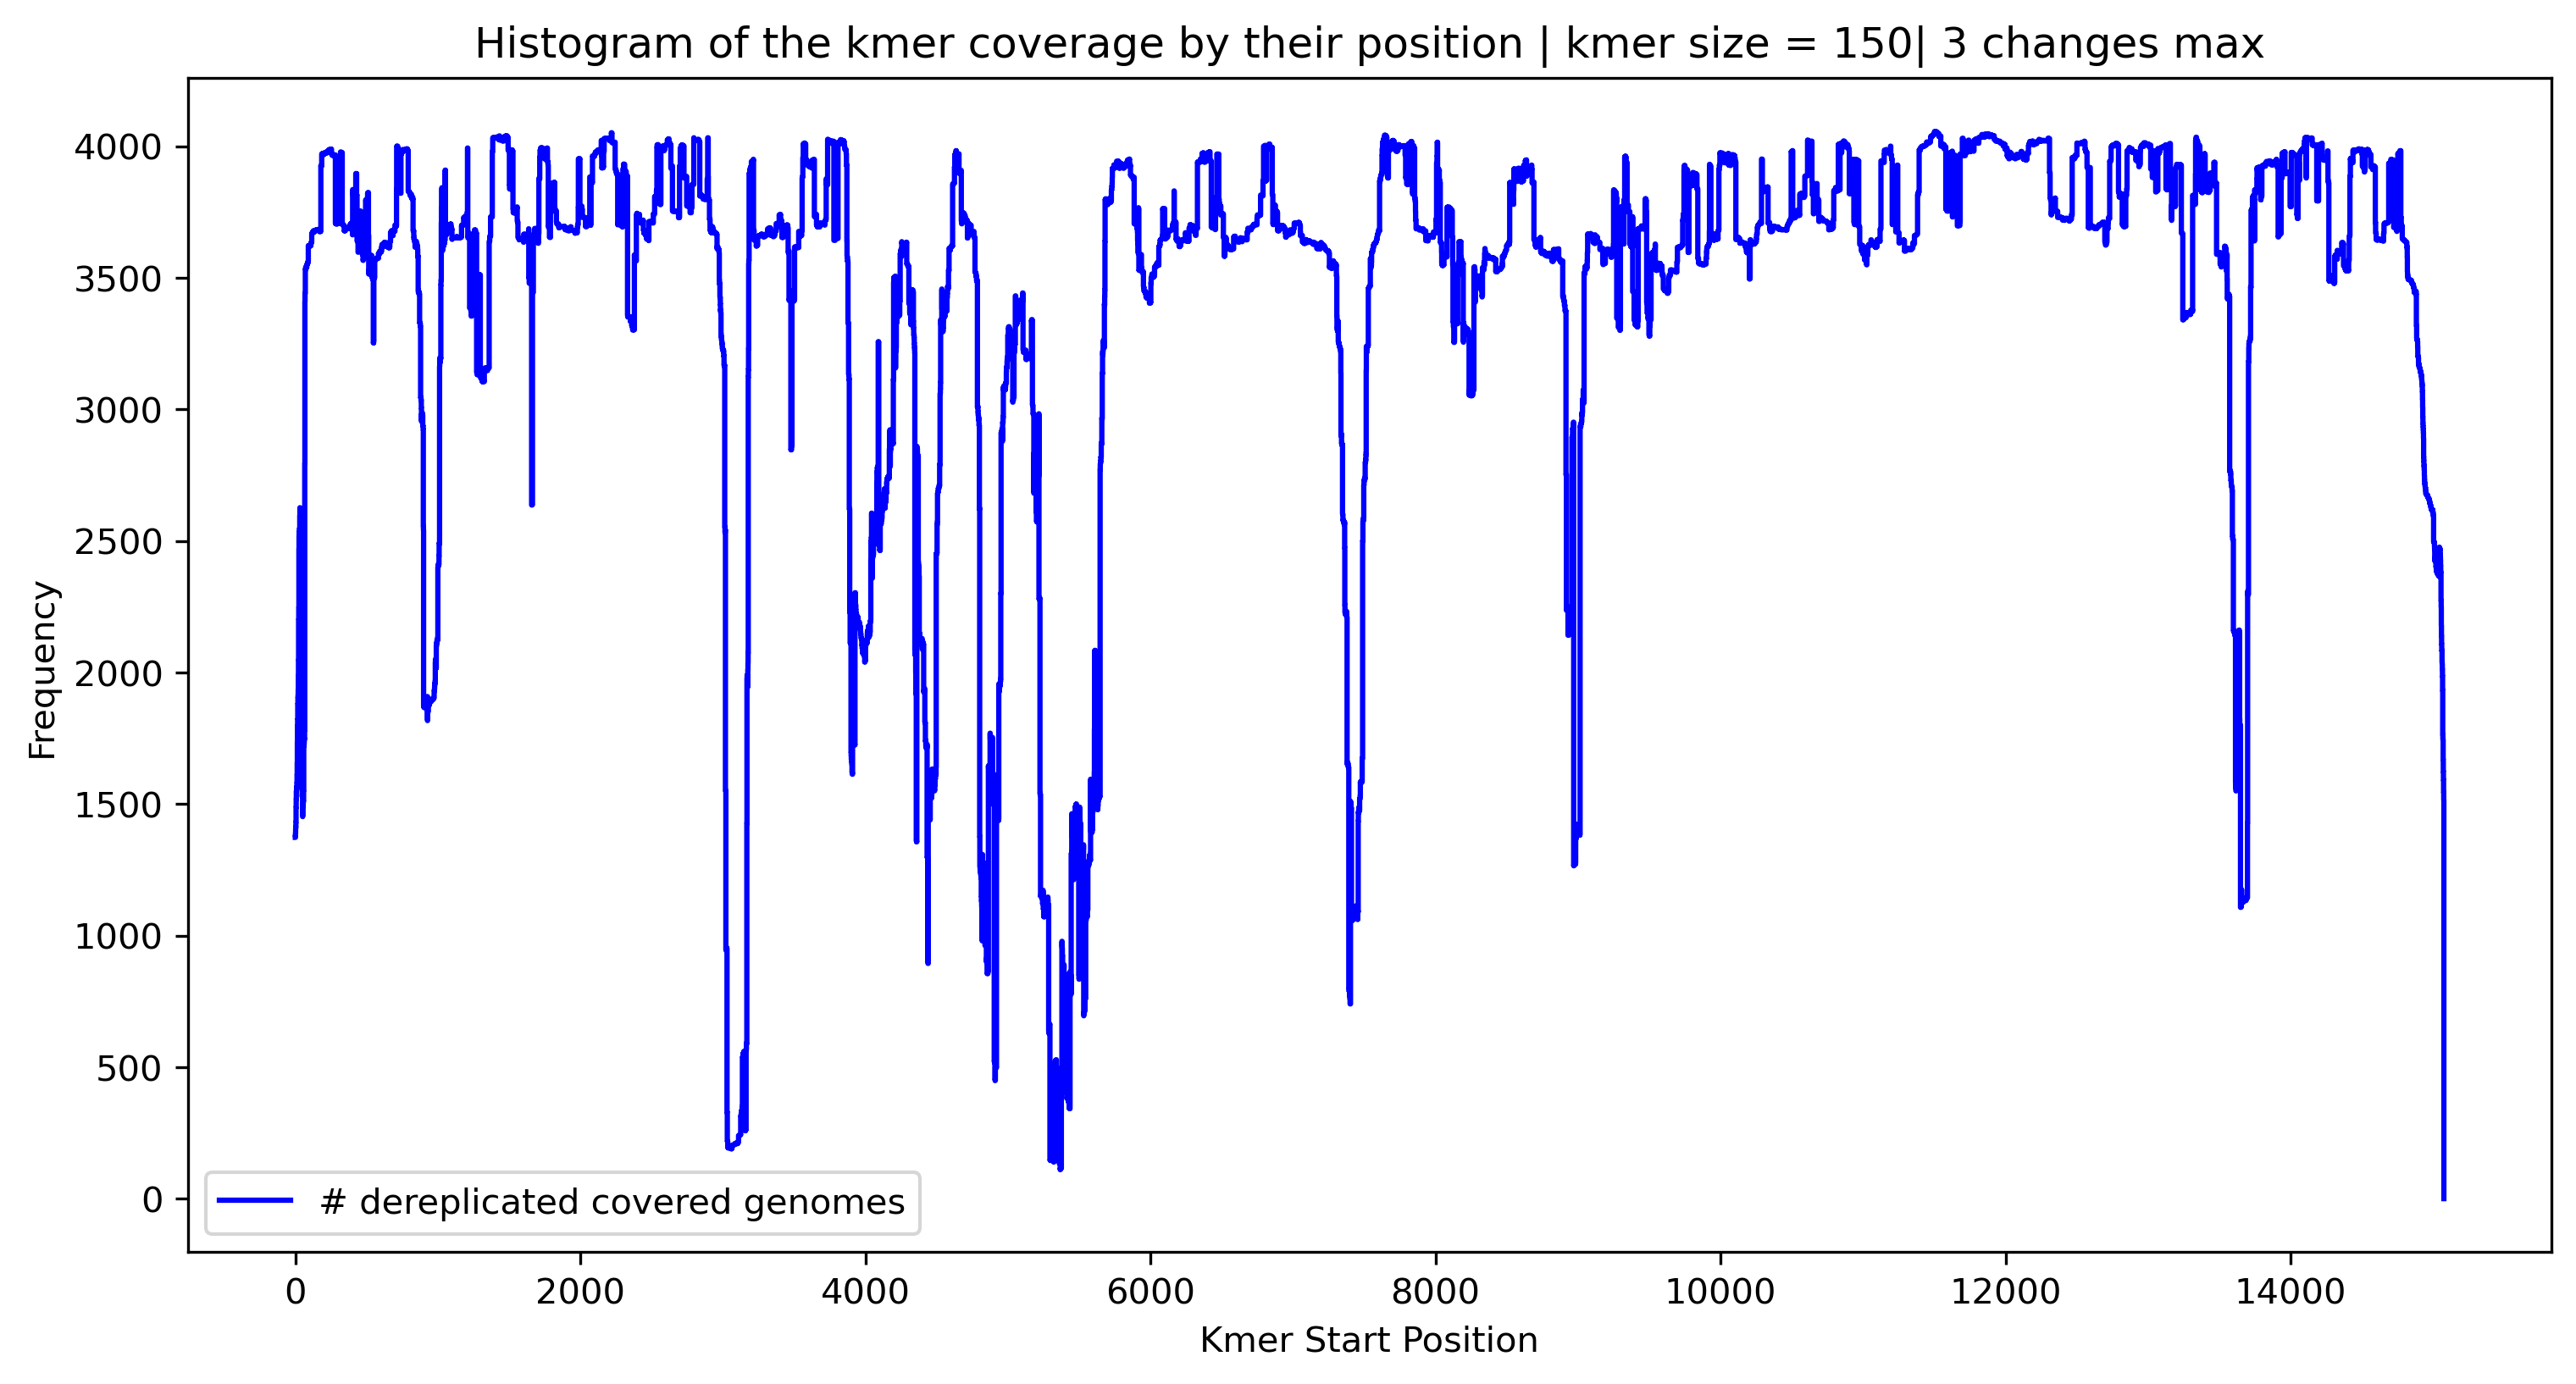

In [87]:
df.columns = df.columns.astype(int)
plot_rel_cons(df)


In [91]:


def read_wig(wig_file_path):
    """
    Reads a WIG file and returns the values as a pandas Series with positions as index.
    """
    positions = []
    values = []
    
    print(f"Reading WIG file: {wig_file_path}")
    with open(wig_file_path, 'r') as wig_file:
        for line in wig_file:
            if line.startswith('variableStep'):
                continue
            parts = line.strip().split()
            if len(parts) == 2:
                position = int(parts[0])
                value = float(parts[1])
                positions.append(position)
                values.append(value)
    data_series = pd.Series(data=values, index=positions)
    print(f"Read {len(data_series)} values from {wig_file_path}")
    return data_series

def prepare_df(folder_path, sub_folder, KMER_SIZE):
    """
    Prepares a DataFrame by reading WIG files from the specified folder.
    """
    print(f"Preparing DataFrame from WIG files in {folder_path}")
    files = os.listdir(folder_path)
    print(f"Found {len(files)} files in {folder_path}")

    data_list = []
    for file in files:
        # path = os.path.join(folder_path, file, sub_folder, f"{file}_{KMER_SIZE}_conservative.wig")
        path = ''.join([folder_path, file, sub_folder, f"{file}_{KMER_SIZE}_conservative.wig"])
        # path = ''.join([folder_path,file, sub_folder, file, f'_{KMER_SIZE}_conservative.wig'])

        # print(folder_path)
        # print(file)
        # print(sub_folder)
        # break
        try:
            data_series = read_wig(path)
            data_series.name = file
            data_list.append(data_series)
            print(f"Added data for {file}")
        except FileNotFoundError:
            print(f"File not found: {path}, skipping.")
            continue

    df = pd.DataFrame(data_list)
    df = df.fillna(0)
    max_sum = df.sum().max()
    print(f"DataFrame prepared. Max sum of values per position: {max_sum}")

    return df

def plot_rel_cons(df, SAMPLE_NAME, KMER_SIZE):
    """
    Plots the histogram of kmer coverage by position.
    """
    print(f"Plotting kmer coverage for sample {SAMPLE_NAME} with kmer size {KMER_SIZE}")
    x = df.columns.values
    y = df.sum().values
    change_indices_y = np.where(y[:-1] != y[1:])[0]
    change_indices_y = np.concatenate(([0], change_indices_y, [len(y) - 1]))
    x_steps_y = x[change_indices_y]
    y_steps = y[change_indices_y]
    x_steps_y = np.append(x_steps_y, x_steps_y[-1] + 1)
    y_steps = np.append(y_steps, 0)
    
    plt.figure(figsize=(12, 6), dpi=300)
    plt.step(x_steps_y, y_steps, where='post', label='# dereplicated covered genomes', color='blue')
    plt.title(f'Histogram of the kmer coverage by position | kmer size = {KMER_SIZE} | 3 changes max')
    plt.xlabel('Kmer Start Position')
    plt.ylabel('Frequency')
    plt.legend()
    output_filename = f'Comparison_of_Conservative_frequencies_{SAMPLE_NAME}_{KMER_SIZE}.png'
    plt.savefig(output_filename, dpi=300)
    print(f"Plot saved as {output_filename}")
    plt.show()

def abundant_kmers(df):
    """
    Finds abundant kmers and the samples covering them.
    """
    print("Finding abundant kmers...")
    data = df.copy()
    output = dict()
    samples = dict()
    while True:
        pos = data.sum().idxmax()
        rep = data.sum().max()
        output[pos] = int(rep)
        print(f"Kmer start pos: {pos} has appeared in {int(rep)} samples / {data.shape[0]} samples")
        samples[pos] = data[data[pos]==1].index.values
        data = data[data[pos]!=1]
        total_remaining = data.sum().sum()
        if total_remaining <1:
            print("No more kmers left to process.")
            break
        else:
            print(f"Remaining kmers to process: {total_remaining}")
    return output, samples

def find_min_coverage_threshold(df, coverage_ratio=0.5):
    """
    Calculates the minimum coverage threshold based on the coverage ratio.
    """
    min_coverage = int(df.shape[0] * coverage_ratio)
    print(f"Minimum coverage threshold set to {min_coverage} based on coverage ratio {coverage_ratio}")
    return min_coverage

def limit_to_l_gene(df, start, end):
    """
    Limits the DataFrame to the specified gene region.
    """
    print(f"Limiting DataFrame to gene region from position {start} to {end}")
    ldf = df.loc[:, (df.columns >= start) & (df.columns <= end)]
    return ldf

def crop_df(df, start, end, coverage_ratio=0.5):
    """
    Crops the DataFrame to the specified gene region and coverage threshold.
    """
    ldf = limit_to_l_gene(df, start, end)
    min_coverage = find_min_coverage_threshold(ldf, coverage_ratio)
    ldf = ldf.loc[:, ldf.sum() > min_coverage]
    print(f"DataFrame cropped to {ldf.shape[1]} columns with coverage above threshold.")
    return ldf

def build_coverage_table(ldf):
    """
    Builds a coverage table for combinations of kmers.
    """
    print("Building coverage table for kmers...")
    data = ldf.values
    column_names = ldf.columns.tolist()
    num_kmers = len(column_names)
    coverage_list = []

    for i, j in itertools.combinations(range(num_kmers), 2):
        k1, k2 = column_names[i], column_names[j]
        union_sum = np.sum((data[:, i] + data[:, j]) > 0)
        k1_cov = data[:, i].sum()
        k2_cov = data[:, j].sum()
        total_cov = k1_cov + k2_cov
        coverage_list.append({
            'k1': k1,
            'k2': k2,
            'union_sum': union_sum,
            'k1_cov': k1_cov,
            'k2_cov': k2_cov,
            'k1_cov_plus_k2_cov': total_cov
        })
    coverage_df = pd.DataFrame(coverage_list)
    coverage_df = coverage_df.loc[(coverage_df[['k1_cov', 'k2_cov', 'union_sum']] != 0).any(axis=1)]
    coverage_df = coverage_df.sort_values(by=['union_sum', 'k1_cov_plus_k2_cov'], ascending=False)
    print(f"Coverage table built with {len(coverage_df)} combinations.")
    return coverage_df

def top_kmers_df(cov_df):
    """
    Returns the top kmers based on maximum union_sum and total coverage.
    """
    max_union_sum = cov_df['union_sum'].max()
    sub_df = cov_df[cov_df['union_sum'] == max_union_sum]
    max_total_cov = sub_df['k1_cov_plus_k2_cov'].max()
    sub_df = sub_df[sub_df['k1_cov_plus_k2_cov'] == max_total_cov]
    print(f"Top kmers found covering {max_union_sum} samples with total coverage {max_total_cov}")
    return sub_df

def read_fasta_to_dataframe(fasta_file):
    """
    Reads a FASTA file and returns a DataFrame with sequence IDs and sequences.
    """
    print(f"Reading FASTA file: {fasta_file}")
    sequences = []
    sequence_id = ''
    sequence = ''
    with open(fasta_file, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if sequence:
                    sequences.append({'ID': sequence_id, 'Sequence': sequence})
                    sequence = ''
                sequence_id = line[1:]
            else:
                sequence += line
        if sequence:
            sequences.append({'ID': sequence_id, 'Sequence': sequence})

    df = pd.DataFrame(sequences)
    print(f"Read {len(df)} sequences from {fasta_file}")
    return df


In [92]:
import pandas as pd

def read_fasta_to_dataframe(fasta_file):
    """Reads a FASTA file and returns a DataFrame with sequence IDs and sequences."""
    with open(fasta_file, 'r') as file:
        sequences = []
        sequence_id = ''
        sequence = ''
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # Header line
                if sequence:  # Save previous sequence before starting a new one
                    sequences.append([sequence_id, sequence])
                    sequence = ''  # Reset sequence
                sequence_id = line[1:]  # Remove '>' and take the rest as ID
            else:
                sequence += line
        if sequence:  # Ensure the last sequence is also added
            sequences.append([sequence_id, sequence])
    
    # Creating a DataFrame
    df = pd.DataFrame(sequences, columns=['ID', 'Sequence'])
    return df


import pandas as pd
from collections import defaultdict, Counter
import re

def extract_year(id_string):
    """
    Extracts the year from the sequence ID.
    Assumes that the year is a 4-digit number following a pipe '|' in the ID.
    """
    match = re.search(r'\|(\d{4})\b', id_string)  # Look for a 4-digit year
    if match:
        return int(match.group(1))  # Convert year to an integer
    return 'No Year'

# Function to decide if the group should be kept or removed
def filter_group_by_year(group, min_year=2020, threshold=100):
    # If the group is smaller than 1% of total rows
    if len(group) < threshold:
        years = group['year']
        # Check if years end in min_year or cross min_year
        if years.max() == min_year:
            if years.min() <min_year:
                return False
        if years.max() < min_year:
            return False         
    return True

# Drop kmers which have more than 3 changes to the most frequent kmer
def filter_kmers_by_changes(df_samples, kmer_name='kmer1', num_changes_threshold=3):
    """
    Filters the DataFrame to return rows where the subsequence has more than a specified number of changes compared to the
    most frequent subsequence and adds a new column showing the number of changes.
    
    Parameters:
    - df_samples: pandas DataFrame with columns ['ID', 'kmer1'].
    - kmer_name: Name of the kmer column (default is 'kmer1').
    - num_changes_threshold: The minimum number of changes to filter by (default is 3).
    
    Returns:
    - DataFrame with rows having more than `num_changes_threshold` changes and a new column 'num_changes' showing the count.
    """
    # Drop rows where 'Subsequence' (kmer1) is NaN
    df_samples_clean = df_samples[['ID', kmer_name]].dropna()

    # Count frequency of each subsequence
    subseq_freq = Counter(df_samples_clean[kmer_name])

    # Sort subsequences by frequency in descending order
    sorted_subsequences = sorted(subseq_freq.items(), key=lambda x: x[1], reverse=True)
    
    # Get the most frequent subsequence
    most_frequent_subseq = sorted_subsequences[0][0]

    # Create a list to hold subsequences with more than the threshold number of changes
    subseq_with_changes = []

    # Iterate through the subsequences and calculate the number of changes
    for idx, row in df_samples_clean.iterrows():
        subseq = row[kmer_name]
        comparison = compare_kmers(subseq, most_frequent_subseq)
        num_changes = len([char for char in comparison if char != '-'])  # Count only the changed characters
        
        # If the number of changes is greater than the threshold, add it to the list
        if num_changes > num_changes_threshold:
            subseq_with_changes.append({
                'ID': row['ID'],
                kmer_name: subseq,
                'num_changes': num_changes
            })

    # Convert the list of results into a DataFrame
    df_with_changes = pd.DataFrame(subseq_with_changes)

    return df_with_changes



import pandas as pd
from collections import defaultdict, Counter
import re

def extract_year(id_string):
    """
    Extracts the year from the sequence ID.
    Assumes that the year is a 4-digit number following a pipe '|' in the ID.
    """
    match = re.search(r'\|(\d{4})\b', id_string)
    if match:
        return int(match.group(1))
    return None

def get_subsequences_with_years(df_samples, kmer_column):
    """
    Extracts subsequences and their associated years from the given DataFrame.

    Parameters:
    - df_samples: pandas DataFrame with columns ['ID', kmer_column].
    - kmer_column: Name of the column containing kmers.

    Returns:
    - subseq_to_years: Dictionary mapping subsequences to associated years.
    - subseq_freq: Counter object for the frequency of subsequences.
    """
    df_clean = df_samples[['ID', kmer_column]].dropna()

    subseq_to_years = defaultdict(list)
    for idx, row in df_clean.iterrows():
        year = extract_year(row['ID'])
        if year:
            subseq_to_years[row[kmer_column]].append(year)
    
    subseq_freq = Counter(df_clean[kmer_column])
    return subseq_to_years, subseq_freq

def get_sorted_subsequences(subseq_freq):
    """
    Sorts subsequences by frequency in descending order.

    Parameters:
    - subseq_freq: Counter object with subsequence frequencies.

    Returns:
    - sorted_subsequences: List of sorted subsequences with their frequencies.
    """
    return sorted(subseq_freq.items(), key=lambda x: x[1], reverse=True)

def compare_sequences(reference, sequence):
    """
    Compares a subsequence to the reference sequence and returns an alignment string.
    Matching positions are replaced with '-', and non-matching positions retain the sequence's character.

    Parameters:
    - reference: The reference subsequence (most frequent).
    - sequence: The sequence to compare.

    Returns:
    - comparison: A string showing the comparison result.
    """
    # If the sequence is the same as the reference, return the sequence itself (no dashes)
    if reference == sequence:
        return reference

    return ''.join('-' if ref_char == seq_char else seq_char for ref_char, seq_char in zip(reference, sequence))

def count_changes(reference, sequence):
    """
    Counts the number of changes between the reference sequence and the given sequence,
    ignoring dashes ('-') in either sequence.

    Parameters:
    - reference: The reference subsequence (most frequent).
    - sequence: The sequence to compare.

    Returns:
    - changes: The number of differences between the sequences where both have valid characters (ignoring dashes).
    """
    changes = 0
    for ref_char, seq_char in zip(reference, sequence):
        if ref_char != '-' and seq_char != '-' and ref_char != seq_char:
            changes += 1
    return changes

def simulate_year_bars(years, total_width=60, start_year=1965, end_year=2025):
    """
    Creates a string of dashes representing the year range based on a list of years.

    Parameters:
    - years: List of years.
    - total_width: Number of characters to represent the year range (default: 40).
    - start_year: Start of the year range (default: 1985).
    - end_year: End of the year range (default: 2025).

    Returns:
    - bar: A string representing the year span using dashes.
    """
    if not years:
        return ' ' * total_width

    min_year, max_year = min(years), max(years)
    start_pos = int(((min_year - start_year) / (end_year - start_year)) * total_width)
    end_pos = int(((max_year - start_year) / (end_year - start_year)) * total_width)

    bar = [' ' for _ in range(total_width)]
    for i in range(start_pos, end_pos + 1):
        bar[i] = '-'
    
    return ''.join(bar)

def create_kmers_dataframe(sorted_subsequences, subseq_to_years, most_frequent_subseq, total_subsequences):
    """
    Creates a DataFrame with Seq_ID, year range, percentage, alignment, and changes.

    Parameters:
    - sorted_subsequences: List of sorted subsequences with their frequencies.
    - subseq_to_years: Dictionary mapping subsequences to years.
    - most_frequent_subseq: The most frequent subsequence (reference).
    - total_subsequences: Total number of subsequences (for percentage calculation).

    Returns:
    - df_kmers: A Pandas DataFrame containing the processed subsequences and associated data.
    """
    data = []
    for i, (subseq, freq) in enumerate(sorted_subsequences, start=1):
        percentage = (freq / total_subsequences) * 100
        years = subseq_to_years[subseq]
        s_year = min(years) if years else None
        e_year = max(years) if years else None
        year_range = simulate_year_bars(years)

        # Handle reference sequence alignment and changes
        if subseq == most_frequent_subseq:
            alignment = subseq  # The reference sequence is shown as is (no dashes)
            changes = 0  # No changes for the reference sequence
        else:
            alignment = compare_sequences(most_frequent_subseq, subseq)
            changes = count_changes(most_frequent_subseq, subseq)

        data.append({
            "Seq_ID": i,
            "s_year": s_year,
            "e_year": e_year,
            "year_range": year_range,
            "percentage": f"{percentage:.2f}%",
            "alignment": alignment,
            "changes": changes
        })

    return pd.DataFrame(data)

def process_kmers_to_dataframe(df_samples, kmer_column):
    """
    Processes kmers and creates a DataFrame with relevant information about each subsequence.

    Parameters:
    - df_samples: Pandas DataFrame containing the sequence data.
    - kmer_column: Name of the column containing kmers.

    Returns:
    - df_kmers: A Pandas DataFrame with Seq_ID, year range, percentage, alignment, and changes.
    """
    subseq_to_years, subseq_freq = get_subsequences_with_years(df_samples, kmer_column)
    sorted_subsequences = get_sorted_subsequences(subseq_freq)
    most_frequent_subseq = sorted_subsequences[0][0]
    total_subsequences = sum(subseq_freq.values())

    return create_kmers_dataframe(sorted_subsequences, subseq_to_years, most_frequent_subseq, total_subsequences)


def compare_kmers(kmer, reference):
    """
    Compares a kmer with a reference sequence and returns a comparison string.
    Matching positions are replaced with '-', and non-matching positions retain the kmer's character.
    """
    result = []
    for i in range(len(kmer)):
        if kmer[i] == reference[i]:
            result.append('-')
        else:
            result.append(kmer[i])
    return ''.join(result)


def pipeline_results_cleaner(sample_address='../data/rsva/samples/aligned/derep.fasta.aln',
                             kmer1=11000, kmer2=12000, drop_old_samples=True,
                             kmer_size= 150, min_year=2020, threshold_ratio=0.01):
    
    df_samples = read_fasta_to_dataframe(sample_address)

    df_samples['kmer1'] = df_samples['Sequence'].str.slice(kmer1, kmer1+kmer_size)
    df_samples['kmer2'] = df_samples['Sequence'].str.slice(kmer2, kmer2+kmer_size)

    df_samples['year'] = df_samples['ID'].apply(extract_year)

    # Convert the 'year' column to numeric, coercing errors to NaN
    df_samples['year'] = pd.to_numeric(df_samples['year'], errors='coerce')

    # Drop rows where 'year' is NaN (i.e., non-numerical entries were converted to NaN)
    df_samples = df_samples.dropna(subset=['year'])

    ## Drop the samples containing Non ATCG chars in their kmer1 or kmer2
    df_samples = df_samples[~df_samples['kmer1'].str.contains('[^ATCG]', regex=True) & 
                            ~df_samples['kmer2'].str.contains('[^ATCG]', regex=True)]
    
    # drop old samples 
    if drop_old_samples:
        # Calculate the threshold for 1% of the total number of rows
        threshold = len(df_samples) * threshold_ratio

        # Group by 'kmer1'
        gk1 = df_samples.groupby('kmer1')
        gk2 = df_samples.groupby('kmer2')

        # Apply the filter and create a new DataFrame with only the groups to be kept
        filtered_df1 = gk1.filter(filter_group_by_year, min_year=min_year, threshold=threshold)
        filtered_df2 = gk2.filter(filter_group_by_year, min_year=min_year, threshold=threshold)

        filtered_ids1 = filtered_df1['ID']
        filtered_ids2 = filtered_df2['ID']

        ids = list(set(filtered_ids1.values).intersection(filtered_ids2.values))
        df_samples = df_samples[df_samples['ID'].isin(ids)]

    # Drop kmers which have more than 3 changes to the most frequent kmer
    df_changes1 = filter_kmers_by_changes(df_samples, kmer_name='kmer1', num_changes_threshold=3)
    df_changes2 = filter_kmers_by_changes(df_samples, kmer_name='kmer2', num_changes_threshold=3)

    ids_to_drop = list(set(df_changes1.ID.tolist()).union(df_changes2.ID.tolist()))
    df_samples = df_samples.loc[~df_samples['ID'].isin(ids_to_drop)]

    df_kmers1 = process_kmers_to_dataframe(df_samples, 'kmer1')
    df_kmers2 = process_kmers_to_dataframe(df_samples, 'kmer2')

    return df_kmers1, df_kmers2



In [96]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Constants
FOLDER_PATH = '../data/rsva/samples/separated/'
SUB_FOLDER = '/a/output_files/'
SAMPLE_NAME = 'derep'
KMER_SIZE = 150
L_GENE_START = 8000
L_GENE_END = 16000
COVERAGE_RATIO = 0.5
REF_FILE = 'EPI_ISL_412866_RSVA_ref.fasta'
REF_ADDRESS = os.path.join('../data/rsva/reference', REF_FILE)

SAMPLE_ADDRESS = '../data/rsva/samples/aligned/derep.fasta.aln'
VARIANT = 'a'

In [94]:

# Main execution
if __name__ == "__main__":
    # Prepare DataFrame from WIG files
    # df = prepare_df(FOLDER_PATH, SUB_FOLDER, KMER_SIZE)
    
    # Plot kmer coverage
    # plot_rel_cons(df, SAMPLE_NAME, KMER_SIZE)
    
    # Find abundant kmers
    sorted_kmers, samples = abundant_kmers(df)
    
    # Crop DataFrame to L gene region and apply coverage threshold
    ldf = crop_df(df, L_GENE_START, L_GENE_END, coverage_ratio=COVERAGE_RATIO)
    
    # Build coverage table
    cov_df = build_coverage_table(ldf)
    
    # Find top kmers
    sub_df = top_kmers_df(cov_df)
    
    set1 = np.unique(sub_df['k1'].values)
    print(f"Set1 kmers: {set1}")

    set2 = np.unique(sub_df['k2'].values)
    print(f"Set2 kmers: {set2}")

    kmer1, kmer2 = int(set1[0]), int(set2[0])
    print(f"Selected kmers: {kmer1}, {kmer2}")
    
    # Find remaining samples not covered by top kmers
    print("Finding remaining samples not covered by top kmers...")
    remaining_samples = df.loc[(df[kmer1] + df[kmer2]) == 0]
    remaining_samples_ids = list(remaining_samples.index)
    print(f"Number of remaining samples: {len(remaining_samples_ids)}")
    
    # # Read reference sequence
    # df_ref_b = read_fasta_to_dataframe(REF_ADDRESS)
    # ref_seq = df_ref_b['Sequence'].values[0]
    
    # # Extract kmer sequences
    # kmer1_seq = ref_seq[kmer1:kmer1+KMER_SIZE]
    # kmer2_seq = ref_seq[kmer2:kmer2+KMER_SIZE]
    
    # print(f"Kmer1 sequence (position {kmer1}):\n{kmer1_seq}")
    # print(f"Kmer2 sequence (position {kmer2}):\n{kmer2_seq}")



Finding abundant kmers...
Kmer start pos: 11505 has appeared in 4056 samples / 4081 samples
Remaining kmers to process: 168766
Kmer start pos: 709 has appeared in 19 samples / 25 samples
Remaining kmers to process: 294
Kmer start pos: 1471 has appeared in 1 samples / 6 samples
No more kmers left to process.
Limiting DataFrame to gene region from position 8000 to 16000
Minimum coverage threshold set to 2040 based on coverage ratio 0.5
DataFrame cropped to 6955 columns with coverage above threshold.
Building coverage table for kmers...
Coverage table built with 24182535 combinations.
Top kmers found covering 4074 samples with total coverage 7999
Set1 kmers: [11505]
Set2 kmers: [12929]
Selected kmers: 11505, 12929
Finding remaining samples not covered by top kmers...
Number of remaining samples: 7


FileNotFoundError: [Errno 2] No such file or directory: '../data/rsva/reference/a/EPI_ISL_412866_RSVA_ref.fasta'

In [97]:
# Read reference sequence
df_ref_b = read_fasta_to_dataframe(REF_ADDRESS)
ref_seq = df_ref_b['Sequence'].values[0]

# Extract kmer sequences
kmer1_seq = ref_seq[kmer1:kmer1+KMER_SIZE]
kmer2_seq = ref_seq[kmer2:kmer2+KMER_SIZE]

print(f"Kmer1 sequence (position {kmer1}):\n{kmer1_seq}")
print(f"Kmer2 sequence (position {kmer2}):\n{kmer2_seq}")



Kmer1 sequence (position 11505):
TGTTATATCGAAGTTTCTATAGAAGAACTCCTGATTTCCTCACAGAGGCTATAGTTCACTCTGTGTTCATACTTAGTTATTATACAAACCATGATTTAAAAGATAAACTTCAAGATCTGTCAGATGATAGATTGAATAAGTTCTTAACAT
Kmer2 sequence (position 12929):
AAATCTGGATCTAATGTTAATTCTAATTTAATATTGGCGCATAAGATATCTGACTATTTTCATAATACTTACATTTTAAGTACTAATTTAGCTGGACATTGGATTCTTATTATACAACTTATGAAAGATTCTAAGGGTATTTTTGAAAAA


In [99]:
# Run the pipeline
df_kmers1_drop_old, df_kmers2_drop_old = pipeline_results_cleaner(sample_address=SAMPLE_ADDRESS,
                                                                 kmer1=kmer1, kmer2=kmer2, drop_old_samples=True,
                                                                 kmer_size= 150, min_year=2020, threshold_ratio=0.01)
df_kmers1_drop_old.to_excel(f"../results/{VARIANT}_kmer1_drop_old.xlsx")
df_kmers2_drop_old.to_excel(f"../results/{VARIANT}_kmer2_drop_old.xlsx")

df_kmers1, df_kmers2 = pipeline_results_cleaner(sample_address=SAMPLE_ADDRESS,
                             kmer1=kmer1, kmer2=kmer2, drop_old_samples=False,
                             kmer_size= 150, min_year=2020, threshold_ratio=0.01)
# df_kmers1.to_excel(f"../results/{VARIANT}_kmer1.xlsx")
# df_kmers2.to_excel(f"../results/{VARIANT}_kmer2.xlsx")

df_kmers1.to_csv(f"../results/{VARIANT}_kmer1.csv")
df_kmers2.to_csv(f"../results/{VARIANT}_kmer2.csv")

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def count_non_gap_characters_from_dataframe(df, sequence_column='alignment'):
    """
    Counts the number of non-gap ('-') characters at each position across all sequences in a DataFrame column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing sequences.
    sequence_column (str): The name of the column containing sequences.

    Returns:
    pd.DataFrame: A DataFrame with positions as the index and counts as the values.
    """
    if sequence_column not in df.columns:
        raise ValueError(f"Column '{sequence_column}' does not exist in the DataFrame.")
    
    sequences = df[sequence_column].tolist()
    
    if not sequences:
        raise ValueError("The list of sequences is empty.")
    
    sequence_length = len(sequences[0])
    
    # Ensure all sequences are of the same length
    for seq in sequences:
        if len(seq) != sequence_length:
            raise ValueError("All sequences must be of the same length.")
    
    # Convert sequences to a 2D NumPy array
    seq_array = np.array([list(seq) for seq in sequences])
    
    # Create a boolean array where True indicates a non-gap character
    non_gap_array = seq_array != '-'
    
    # Sum over the sequences to get counts at each position
    counts = non_gap_array.sum(axis=0)
    
    # Create a DataFrame from the counts
    df_counts = pd.DataFrame({
        'Position': range(1, sequence_length + 1),
        'NonGapCount': counts
    })
    
    df_counts.set_index('Position', inplace=True)
    return df_counts

def plot_non_gap_counts(df_counts, title='Non-Gap Character Counts at Each Position'):
    """
    Plots the counts of non-gap characters at each position and saves the plot based on the title.

    Parameters:
    df_counts (pd.DataFrame): DataFrame containing counts of non-gap characters at each position.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.bar(df_counts.index, df_counts['NonGapCount'], color='blue')
    plt.xlabel('Position')
    plt.ylabel('Number of Non-Gap Characters')
    plt.title(title)
    plt.tight_layout()
    
    # Generate a filename based on the title
    filename = title.replace(' ', '_') + '.png'
    
    # Save the plot to a file
    plt.savefig(filename)
    print(f"Plot saved as {filename}")
    
    # Close the plot to free up memory
    plt.close()


In [104]:
df_counts = count_non_gap_characters_from_dataframe(df_kmers1_drop_old, sequence_column='alignment') -1
plot_non_gap_counts(df_counts, title=f'{VARIANT}**kmers1_drop_old -- Non-Gap Character Counts at Each Position')

df_counts = count_non_gap_characters_from_dataframe(df_kmers2_drop_old, sequence_column='alignment') -1
plot_non_gap_counts(df_counts, title=f'{VARIANT}**kmers2_drop_old -- Non-Gap Character Counts at Each Position')

df_counts = count_non_gap_characters_from_dataframe(df_kmers1, sequence_column='alignment') -1
plot_non_gap_counts(df_counts, title=f'{VARIANT}**kmers1 -- Non-Gap Character Counts at Each Position')

df_counts = count_non_gap_characters_from_dataframe(df_kmers2, sequence_column='alignment') -1
plot_non_gap_counts(df_counts, title=f'{VARIANT}**kmers2 -- Non-Gap Character Counts at Each Position')

Plot saved as a**kmers1_drop_old_--_Non-Gap_Character_Counts_at_Each_Position.png
Plot saved as a**kmers2_drop_old_--_Non-Gap_Character_Counts_at_Each_Position.png
Plot saved as a**kmers1_--_Non-Gap_Character_Counts_at_Each_Position.png
Plot saved as a**kmers2_--_Non-Gap_Character_Counts_at_Each_Position.png


In [105]:
df_counts

,NonGapCount
Position,
1,0
2,0
3,6
4,0
5,0
...,...
146,0
147,2
148,0
